In [1]:
import pandas as pd
from scipy.spatial.distance import pdist, jaccard
from scipy.stats import pearsonr,spearmanr
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import correlation,cosine
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt
import numpy as np
from seaborn import heatmap
%matplotlib inline

In [2]:
df = pd.read_csv('spectra/Sample Plots Raw Batch 1.csv',delimiter="\t")

In [3]:
df

,kDa,C1:1,C1:2,C1:3,C1:4,C1:5,C1:6,C1:7,C1:8,C1:9,C1:10,C1:11,C1:12,C1:13
0,-17.6680,67.8632,0.0000,99.0166,0.0,0.0000,0.0000,0.0,291.4464,0.0,0.0000,0.0000,0.0000,0.0000
1,-17.5959,65.7341,0.0000,100.4004,0.0,0.0000,103.7376,0.0,288.6779,0.0,0.0000,0.0000,0.0000,56.3523
2,-17.5237,62.8133,0.0000,101.7775,0.0,0.0000,107.2871,0.0,285.2138,0.0,0.0000,74.3646,0.0000,59.2128
3,-17.4516,54.3518,85.6569,104.1036,0.0,0.0000,108.8890,0.0,281.7496,0.0,0.0000,77.4150,0.0000,59.2542
4,-17.3795,52.4840,93.0369,106.5132,0.0,0.0000,110.9166,0.0,278.9719,0.0,0.0000,80.9792,76.3006,58.9507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,115.7226,0.0000,110.0747,124.6721,0.0,124.2915,139.2019,0.0,0.0000,0.0,134.9431,132.6216,108.1523,92.1495
793,115.9692,0.0000,110.6106,126.0760,0.0,125.3945,139.6927,0.0,0.0000,0.0,133.9253,130.5809,106.6845,93.3550
794,116.2158,0.0000,110.6058,126.2470,0.0,123.1688,138.1927,0.0,0.0000,0.0,133.1259,128.7632,107.2420,0.0000
795,116.4624,0.0000,0.0000,124.1793,0.0,120.4059,137.0804,0.0,0.0000,0.0,131.2639,126.0435,108.4751,0.0000


In [4]:
df2 = df[(df['kDa']>=2) & (df['kDa']<=40)]

In [5]:
import numpy as np
array = np.array([],dtype='uint8')

In [6]:
def generate_spectra(df):
    """
    Generate occurrence matrix from dataframe
    
    Parameters
    ----------
    df : dataframe
         A dataframe where the first row contains the names of the samples and for each sample we have its spectra
    
    Returns
    ----------
    matrix : narray
             The spectra associated with each sample
    names  : list
             The list of names of the samples
    """
    
    names = df.columns[1:]
        
    
    return np.transpose(df.values[:,1:]), names   

In [7]:
def compute_distance(vector1,vector2,metric='correlation'):
    if(metric=='correlation'):
        return correlation(vector1,vector2)
    if(metric=='cosine'):
        return cosine(vector1,vector2)

In [8]:
def generate_similarity_matrix(df,metric='correlation'):
    # We group the mws of each sample
    spectra,names = generate_spectra(df)
    
    matrix  = np.zeros((len(names),len(names)),dtype='float32')
    for i in range(0,len(names)):
        for j in range(i+1,len(names)):
            matrix[i][j] = compute_distance(spectra[i],
                                            spectra[j],
                                            metric)
            matrix[j][i] = matrix[i][j]
    return matrix, names

In [9]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [10]:
def generate_dendogram(df,linkage='average',metric='correlation',threshold=0.35,name='dendogram.jpg'):
    """
    Generate occurrence matrix from dataframe
    
    Parameters
    ----------
    df : dataframe
        A dataframe where the first column contains the names of the samples and the second
        contains the molecular weights
    linkage: string
        The linkage method for building the dendogram:
        ‘ward’, ‘complete’, ‘average’, ‘single’.
    metric: string
        One of the following metrics to compute the distance matrix:
        'pearson' or 'spearman'
    threshold: float >=0 and <=1
        Value that is considered to create a cluster. 
    name: string
        Path where the dendogram will be saved
    Returns
    ----------
    This methods shows the associated dendogram and saves the image.
    """

    if(metric=='correlation' or metric=='cosine'):            
        m,names = generate_similarity_matrix(df,metric)
    else:
        raise Excepction('Only jaccard and dice are supported')
    
    clustering = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage=linkage,
                                      distance_threshold=threshold)
    clustering.fit(m)
    
    plot_dendrogram(clustering,leaf_font_size=10.,orientation='left',labels = names)
    plt.savefig(name)
    

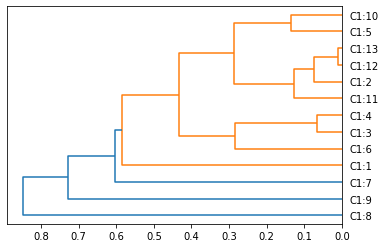

In [11]:
generate_dendogram(df)

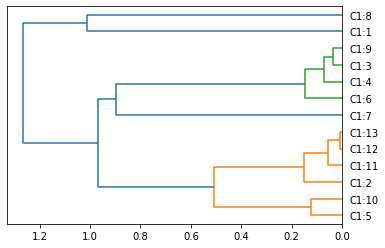

In [12]:
generate_dendogram(df2)

In [17]:
def generate_heatmap(df,metric='correlation',name='heatmap.jpg'):
    m,names = generate_similarity_matrix(df,metric)
    plt.figure(figsize=(len(names)+1, len(names)))
    heatmap(1-m,xticklabels=names,yticklabels=names,annot=True)
    plt.savefig(name)

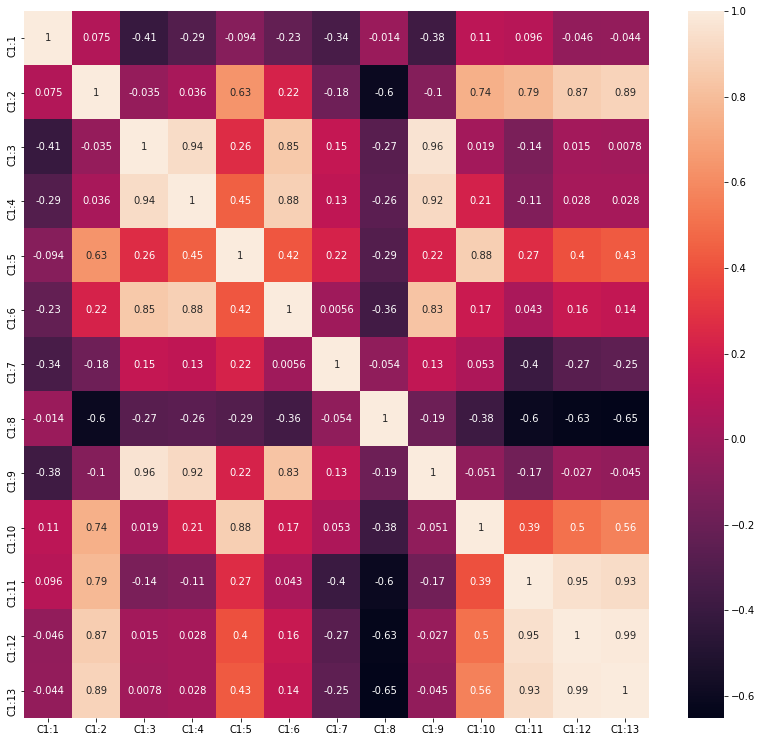

In [18]:
generate_heatmap(df2)

In [15]:
df = pd.read_csv('spectra/Sample Plots Batch 1.csv',delimiter="\t")

In [16]:
df2 = df[(df['kDa']>=2) & (df['kDa']<=40)]

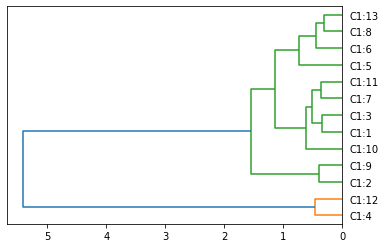

In [17]:
generate_dendogram(df2)